In [6]:
!pip install wordsegment
!pip install nltk
!pip install keras
!pip install tensorflow
!pip install swifter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 61.6 MB/s eta 0:00:00


IMPORT LIBRARIES

In [7]:
import pandas as pd
import numpy as np
import nltk
import re
from wordsegment import load, segment, clean
load() #loading segment
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import swifter

%matplotlib inline

NLTK

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

NLTK stopwords

In [9]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

In [10]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
word_tokenize("I love NLP!")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['I', 'love', 'NLP', '!']

reduce to its base form


In [11]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize("acknowledging", pos="v")


'acknowledge'

LOADING DATASET

In [12]:
df = pd.read_csv('/content/drive/MyDrive/Dl assignment /labeled_data.csv',header = 'infer')
df.head()

,tweet,Class Label
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [13]:
print('number of rows and columns i.e. dimension of the dataset: ',df.shape)
print('\ncolumn names of the dataset: ',df.columns)

number of rows and columns i.e. dimension of the dataset:  (24783, 2)

column names of the dataset:  Index(['tweet', 'Class Label'], dtype='object')


In [14]:
ClassLabel = df['Class Label']
tweets = df.tweet

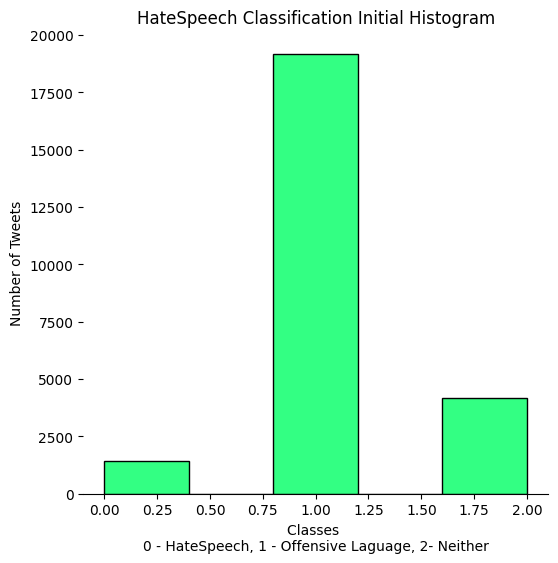

In [15]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.hist(ClassLabel, bins=5, color='#33FF83', density=False, edgecolor='black')
plt.title('HateSpeech Classification Initial Histogram')
plt.xlabel('Classes \n0 - HateSpeech, 1 - Offensive Laguage, 2- Neither')
plt.ylabel('Number of Tweets')
plt.show()

# **PREPROCESSING**

In [16]:
corpus = []
lemmatizer = WordNetLemmatizer()

exclusions = ["#ff", "ff", "rt", "\"\"\""]

char_regExp = '[,\?:\|]'
quoteHtml_regExp = '(&#8220;)|(&#8221;)'
andHtml_regExp = '(&amp;)'
emo_regExp = '&#(\d+);'
space_pattern = '\s+'
giant_url_regex = 'http[s]?://...'
mention_regex = '@[\w\-]+'

"""
char_regExp = '[,\?:\|]' → removes punctuation like commas, colons, |.
quoteHtml_regExp = '(&#8220;)|(&#8221;)' → removes encoded quotes (HTML entities).
andHtml_regExp = '(&amp;)' → removes HTML code for &.
emo_regExp = '&#(\d+);' → removes encoded emojis/symbols.
space_pattern = '\s+' → replaces multiple spaces with one.
giant_url_regex = 'http[s]?://...' → removes URLs.
mention_regex = '@[\w\-]+' → removes Twitter @mentions.
"""

def preprocess(tweet):
    tweet = re.sub(space_pattern, ' ', tweet)       # remove extra spaces
    tweet = re.sub(giant_url_regex, '', tweet)      # remove URLs
    tweet = re.sub(mention_regex, '', tweet)        # remove @mentions
    tweet = re.sub(char_regExp, '', tweet)          # remove punctuation
    tweet = re.sub(quoteHtml_regExp, '', tweet)     # remove encoded quotes
    tweet = re.sub(andHtml_regExp, '', tweet)       # remove '&' HTML
    tweet = re.sub(emo_regExp, '', tweet)           # remove emojis

    tweet = clean(tweet)       # custom function: further text cleaning
    words = segment(tweet)     # custom function: word segmentation
    filtered_tokens = [w for w in words if not w in exclusions]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    tweet = " ".join(lemmatized_tokens)
    return tweet


<>:6: SyntaxWarning: invalid escape sequence '\?'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\?'
<>:6: SyntaxWarning: invalid escape sequence '\?'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipython-input-2023131088.py:6: SyntaxWarning: invalid escape sequence '\?'
  char_regExp = '[,\?:\|]'
/tmp/ipython-input-2023131088.py:9: SyntaxWarning: invalid escape sequence '\d'
  emo_regExp = '&#(\d+);'
/tmp/ipython-input-2023131088.py:10: SyntaxWarning: invalid escape sequence '\s'
  space_pattern = '\s+'
/tmp/ipython-input-2023131088.py:12: SyntaxWarning: invalid escape sequence '\w'
  mention_regex = '@[\w\-]+'
/tmp/ipython-input-2023131088.py:15: SyntaxWarning: invalid escape

In [17]:

preprocess("!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...")

'a a woman you shouldnt complain about cleaning up your house a a man you should always take the trash out'

In [18]:
preprocess("RT @KarenRFM: No-TV-During-the-Week #parenting rule has thrown quite a monkey wrench")

'not v during the week parenting rule ha thrown quite a monkeywrench'

APPLY TO DATASET


In [ ]:
corpus = tweets.swifter.apply(preprocess)
corpus.head()

In [ ]:
df1 = pd.DataFrame(corpus)
df1['ClassLabel'] = ClassLabel
df1.columns = ['tweets','ClassLabel']

In [ ]:
df1.head()

CLASS WEIGHTS

Tell Keras to pay more attention to the minority class

In [25]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train.argmax(axis=1))  # if one-hot
class_weights = compute_class_weight(
    class_weight={0: 1.0, 1: 3.0, 2: 2.0},
    classes=classes,
    y=y_train.argmax(axis=1)
)
class_weights = dict(zip(classes, class_weights))

# **MODELS**



*   BiLSTM
*   RNN
*   GRU














**BiLSTM**

In [20]:
#LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional,Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [21]:
df = pd.read_csv('/content/drive/MyDrive/Dl assignment /pre-processed.csv',header = 'infer')

In [22]:
ClassLabel = df['ClassLabel']
tweets = df.tweets

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [63]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, ClassLabel, test_size=0.2, random_state=110123184)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=110123184)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [39]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_sequence_length))
model_LSTM.add(Bidirectional(LSTM(units=100)))
model_LSTM.add(Dense(3, activation='sigmoid'))

model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
history = model_LSTM.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


434/434 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7959 - loss: 0.3686 - val_accuracy: 0.8764 - val_loss: 0.2249
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9061 - loss: 0.1793 - val_accuracy: 0.8843 - val_loss: 0.2127
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9274 - loss: 0.1478 - val_accuracy: 0.8791 - val_loss: 0.2238
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9364 - loss: 0.1179 - val_accuracy: 0.8778 - val_loss: 0.2288
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9542 - loss: 0.0889 - val_accuracy: 0.8764 - val_loss: 0.2518
Epoch 5: early stopping


In [40]:
from sklearn.metrics import classification_report
y_pred = np.argmax(model_LSTM.predict(X_test), axis=1)
y_test = y_test.T
print(classification_report(y_test, y_pred))

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.42      0.21      0.28       292
           1       0.91      0.94      0.93      3851
           2       0.76      0.81      0.78       814

    accuracy                           0.87      4957
   macro avg       0.70      0.65      0.66      4957
weighted avg       0.86      0.87      0.86      4957



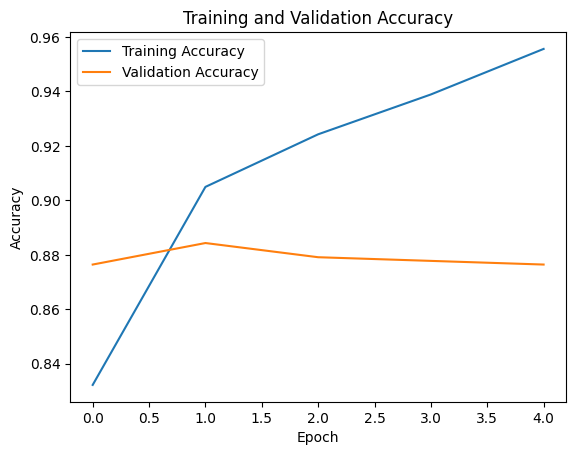

In [41]:
plt.plot(history.history['accuracy'], label='Training Accuracy')

if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

**RNN**

In [42]:
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_sequence_length))
model_RNN.add(Flatten())
model_RNN.add(Dense(3, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
model_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
history = model_RNN.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7772 - loss: 0.4120 - val_accuracy: 0.8574 - val_loss: 0.2474
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8844 - loss: 0.2199 - val_accuracy: 0.8717 - val_loss: 0.2225
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9196 - loss: 0.1600 - val_accuracy: 0.8764 - val_loss: 0.2156
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9395 - loss: 0.1290 - val_accuracy: 0.8739 - val_loss: 0.2192
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9582 - loss: 0.0969 - val_accuracy: 0.8699 - val_loss: 0.2262
Epoch 6/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9704 - loss: 0.0767 - val_accuracy: 0.8670 - val_loss: 0.2385
Epoch 6: early stopping


In [44]:
from sklearn.metrics import classification_report
y_pred = np.argmax(model_RNN.predict(X_test), axis=1)
y_test = y_test.T
print(classification_report(y_test, y_pred))

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.51      0.26      0.35       292
           1       0.90      0.95      0.92      3851
           2       0.78      0.73      0.75       814

    accuracy                           0.87      4957
   macro avg       0.73      0.65      0.68      4957
weighted avg       0.86      0.87      0.86      4957



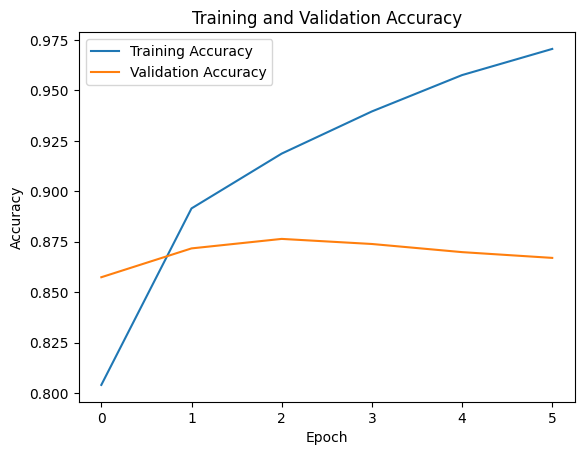

In [45]:
plt.plot(history.history['accuracy'], label='Training Accuracy')


if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

**GRU**

In [46]:
from tensorflow.keras.layers import GRU

model_GRU = Sequential()
model_GRU.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=32,
                        input_length=max_sequence_length))

model_GRU.add(Bidirectional(GRU(units=100)))
model_GRU.add(Dense(3, activation='sigmoid'))  # 3 classes
model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

history = model_GRU.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    class_weight=class_weights
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


434/434 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8002 - loss: 0.7535 - val_accuracy: 0.8826 - val_loss: 0.2197
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9078 - loss: 0.3018 - val_accuracy: 0.8830 - val_loss: 0.2301
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9302 - loss: 0.2225 - val_accuracy: 0.8761 - val_loss: 0.2522
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9410 - loss: 0.1665 - val_accuracy: 0.8766 - val_loss: 0.2484
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


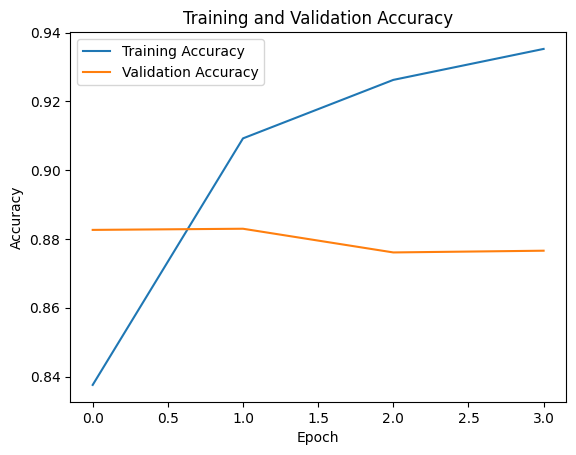

In [47]:
plt.plot(history.history['accuracy'], label='Training Accuracy')


if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [60]:
from sklearn.metrics import classification_report
import pandas as pd

# Get predictions for each model
y_pred_lstm = np.argmax(model_LSTM.predict(X_test), axis=1)
y_pred_rnn = np.argmax(model_RNN.predict(X_test), axis=1)
y_pred_gru = np.argmax(model_GRU.predict(X_test), axis=1)

# Generate classification reports
report_lstm = classification_report(y_test, y_pred_lstm, output_dict=True)
report_rnn = classification_report(y_test, y_pred_rnn, output_dict=True)
report_gru = classification_report(y_test, y_pred_gru, output_dict=True)

# Create a dictionary to store weighted avg metrics
metrics_data = {
    'Model': ['BiLSTM', 'RNN', 'BiGRU'],
    'Precision (Weighted Avg)': [report_lstm['weighted avg']['precision'], report_rnn['weighted avg']['precision'], report_gru['weighted avg']['precision']],
    'Recall (Weighted Avg)': [report_lstm['weighted avg']['recall'], report_rnn['weighted avg']['recall'], report_gru['weighted avg']['recall']],
    'F1-Score (Weighted Avg)': [report_lstm['weighted avg']['f1-score'], report_rnn['weighted avg']['f1-score'], report_gru['weighted avg']['f1-score']],
    'Accuracy': [report_lstm['accuracy'], report_rnn['accuracy'], report_gru['accuracy']]
}

# Create a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
display(metrics_df)

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Precision (Weighted Avg),Recall (Weighted Avg),F1-Score (Weighted Avg),Accuracy
0,BiLSTM,0.859927,0.873109,0.864249,0.873109
1,RNN,0.859359,0.871898,0.862705,0.871898
2,BiGRU,0.832345,0.884809,0.857763,0.884809


In [61]:
import pickle

# Save the LSTM model
model_LSTM.save('model_Bilstm.h5')
print("BILSTM model saved as model_lstm.h5")

# If you still want to see how to save/load other data using pickle, the code below is an example.
# You can uncomment it if needed.
# # Save the object to a file using pickle
# with open('my_data.pkl', 'wb') as f:
#     pickle.dump(my_data, f)

# print("Object saved to my_data.pkl")

# # Load the object from the file using pickle
# with open('my_data.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)

# print("Object loaded from my_data.pkl:")
# print(loaded_data)

BILSTM model saved as model_lstm.h5


In [62]:
# Save the GRU model (as it had the highest accuracy)
model_GRU.save('model_Bigru.h5')
print("BiGRU model saved as model_gru.h5")

BiGRU model saved as model_gru.h5


In [54]:
# Example usage of the predict_realtime function with the LSTM model
input_text = "I Dislike this movie so much"
predicted_label = predict_realtime(input_text, model_LSTM, tokenizer, max_sequence_length)

# Map the predicted label back to the original class meaning
label_map = {0: 'HateSpeech', 1: 'Offensive Language', 2: 'Neither'}
predicted_class_meaning = label_map.get(predicted_label, 'Unknown Class')

print(f"Input Text: '{input_text}'")
print(f"Predicted Class Label: {predicted_label} ({predicted_class_meaning})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Input Text: 'I Dislike this movie so much'
Predicted Class Label: 1 (Offensive Language)


In [59]:
import numpy as np

def predict_realtime(text, model, tokenizer, max_sequence_length):
    """
    Predicts the class label for a given text using the trained model.

    Args:
        text (str): The input text to classify.
        model: The trained Keras model.
        tokenizer: The fitted Keras Tokenizer.
        max_sequence_length (int): The maximum sequence length used during training.

    Returns:
        int: The predicted class label (0, 1, or 2).
    """
    # Preprocess the text (assuming you have the preprocess function defined)
    preprocessed_text = preprocess(text)

    # Tokenize the text
    sequence = tokenizer.texts_to_sequences([preprocessed_text])

    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    # Predict the class probabilities
    prediction = model.predict(padded_sequence)

    # Get the class label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)[0]

    return predicted_class

# Example usage (replace 'Your input text here' with the text you want to classify)
input_text = "i"
predicted_label = predict_realtime(input_text, model_LSTM, tokenizer, max_sequence_length)

# Map the predicted label back to the original class meaning
label_map = {0: 'HateSpeech', 1: 'Offensive Language', 2: 'Neither'}
predicted_class_meaning = label_map.get(predicted_label, 'Unknown Class')

print(f"Input Text: '{input_text}'")
print(f"Predicted Class Label: {predicted_label} ({predicted_class_meaning})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Input Text: 'i kill you nigga'
Predicted Class Label: 1 (Offensive Language)
